<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Load-packages-and-data" data-toc-modified-id="Load-packages-and-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load packages and data</a></span></li><li><span><a href="#Dimensionality-Reduction" data-toc-modified-id="Dimensionality-Reduction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dimensionality Reduction</a></span></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predictive models</a></span><ul class="toc-item"><li><span><a href="#SVM-with-RBF-Kernel" data-toc-modified-id="SVM-with-RBF-Kernel-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>SVM with RBF-Kernel</a></span><ul class="toc-item"><li><span><a href="#With-principal-components:" data-toc-modified-id="With-principal-components:-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>With principal components:</a></span></li><li><span><a href="#Original-data/no-principal-components" data-toc-modified-id="Original-data/no-principal-components-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Original data/no principal components</a></span></li><li><span><a href="#Old-version:-Prior-with-gamma-centered-at-1/30" data-toc-modified-id="Old-version:-Prior-with-gamma-centered-at-1/30-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Old version: Prior with gamma centered at 1/30</a></span></li></ul></li></ul></li><li><span><a href="#Save/Load" data-toc-modified-id="Save/Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save/Load</a></span></li></ul></div>

## Overview
This notebook estimates the more computationally expensive model (those that I could not train within 1-2 days on my laptop). I pursue four strategies to make estimating these more complex models feasible: Using only a subset of observations (training set size of 100,000 observations), reducing the number of features by about three quarters using principal component analysis, using a single validation set rather than using k-fold cross-validation, and running the notebook on AWS to use more powerful hardware.

## Load packages and data

In [12]:
import pdb 
import glob
import copy
import math
import pickle
import csv

import boto3
import uuid
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval, pyll

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, \
    GridSearchCV, StratifiedShuffleSplit, ShuffleSplit, \
    cross_val_score, StratifiedKFold

from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression, \
#     LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature


# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

We will use Boto 3 again to interact with S3 from our notebook.

In [2]:
# Create boto3 resource to interact with S3
s3 = boto3.resource('s3')

In the previous notebook, we uploaded our preprocessed data from the local machine to a S3 bucket. Let's now download these data to our EC2 instance.

In [ ]:
# Create folder to store data
!mkdir data_processed  

# Download files from S3 bucket
bucket_name = 'lending-club-a7b2c3e3-07f7-4444-b258-5bb63c282398'
filenames = ['X_train', 'X_test', 'y_train', 'y_test', 'feature_names']
for filename in filenames:
    s3.Object(bucket_name, f'{filename}.joblib') \
        .download_file(f'data_processed/{filename}.joblib')

Now we can load the data from disk.

In [13]:
# Load preprocessed training and test set, incl. feature names 
X_train = joblib.load('data_processed/X_train.joblib')
X_test = joblib.load('data_processed/X_test.joblib')
y_train = joblib.load('data_processed/y_train.joblib')
y_test = joblib.load('data_processed/y_test.joblib')
feature_names = joblib.load('data_processed/feature_names.joblib')

Since the full data set is too large to fit a SVM with RBF or polynomial kernel, we create smaller subsets with 50,000 observations for the training set (only 10,000 of which will actually be used for training, the remaining will be used for validation).

In [3]:
# Create smaller subsets from data for SVMs
X_train_s, y_train_s = resample(
    X_train, y_train, 
    replace=False, n_samples=50000, random_state=1)

## Dimensionality Reduction

Another step to make the models less computationally expensive is to reduce the dimensionality of the data set.  To that end, let's perform principal component analysis to determine whether the data lie in a lower dimensional subspace. 

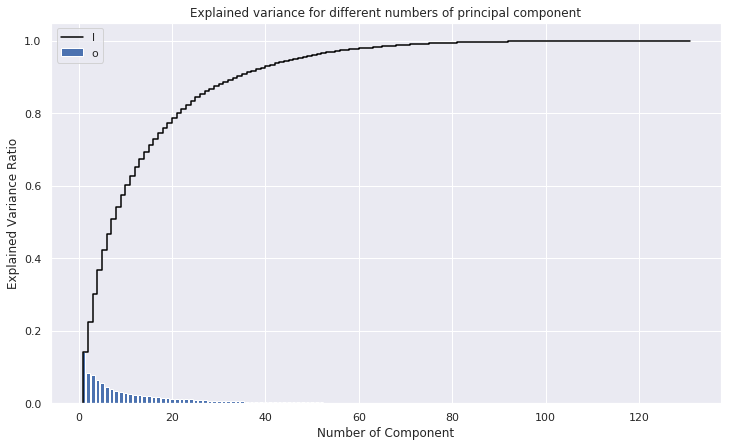

In [18]:
# Use PCA to assess whether features lie in lower-dimensional subspace
pca = PCA()
pca.fit(X_train)
explained_var = pca.explained_variance_ratio_

# Plot results
plt.figure(figsize=(12, 7))
plt.step(range(1, len(explained_var)+2),
         np.hstack([[0], np.cumsum(explained_var)]),
         color='black', label='Cumulative')
plt.bar(range(1, len(explained_var)+1),
        explained_var, 
        label='per principal component')
plt.legend('lowerright')
plt.title('Cumulative and per-component explained variance')
plt.ylim(0,1.05)
plt.xlabel('Number of Component')
plt.ylabel('Explained Variance Ratio')
plt.show();

The above plot shows the explained variance for principal component (blue bars), as well as the cumulative explained variance. This reveals that the first 20 principal components explain about 80% of the variance, and the first 50 principal components explain roughly 95% of the variance. 

I thus decide that the first 30 principal components, which explain close to 90% of the variance, give a good-enough lower-dimensional representation of the data. This reduction number of dimensions by over three quarters should make the models considerably faster to train.

In [4]:
# Project data onto the first 30 principal components
pca = PCA(n_components=30)
X_train_pc = pca.fit_transform(X_train) 
X_test_pc = pca.transform(X_test)

# Create smaller subsets from principal components
X_train_pc_s, y_train_pc_s = resample(
    X_train_pc, y_train,
    replace=False, n_samples=100000, random_state=1)

## Predictive models

We will again define dictionaries to hold important results from each model (average precision score, classification report, and future importance).

In [21]:
# Initialize dictionaries to store results
average_precisions = {}
classification_reports = {}
classification_reports_default_thresholds = {}
feature_importances = {}

In [ ]:
# If these objects already (partially) exist, load them
average_precisions = joblib.load(
    'saved_models/average_precisions.joblib')
feature_importances = joblib.load(
    'saved_models/feature_importances.joblib')

Before proceeding to train the models, I switch to a more powerful EC2 instance type. My decision on the most appropriate type was primarily based on two considerations:

First, note that the code will be single-threaded, because Hyperopt does not natively support parallelization.  For the other learners in the previous notebook, multi-threading was achieved through scikit-learn's cross validator class. Here however, I only use a *single* validation set, because I will be  training more computationally expensive models. Thus, it is worth trading a slightly higher variance in the validation score for considerable savings in computation.

Secondly, note that my models – SVM's with RBF and polynomial kernels – achieve a considerable speed-up if we dedicate a large amount of memory to them.

With these considerations in mind, I chose a r5.large instance, as it offered\s the largest amount of memory (16GB) and one of the highest computational capacities (9 ECUs) of all instances with one or two virtual CPUs. While one CPU would have been sufficient, none of these instances offered enough memory.

### SVM with RBF-Kernel

The strength of an SVM with an RBF kernel is in modeling *non-linear* relationships. Its weakness is that it does not scale well: According to scikit-learn's documentation, it is only recommended up to a couple tens of thousasands of observations. 

I will tune two hyperparameters, gamma and C. Let's think about what an appropriate prior year distribution for each of these would look like. For gamma, the neighborhood size, we will use a log-normal distribution. As mentioned in the previous note book, this distribution lets us concentrate probability mass on the most likely values in the center, but does so on a logarithmic scale. For the distribution's center, we use scikit-learn's default value, the inverse of the number of features. In our case this amounts to 1/130 for the full data set and 1/30 for the principal components. One potential point of confusion is that – as mentioned in a previous notebook – hyperopt uses the *natural* exponential function, whereas np.logspace (which we would often use with grid search) uses base 10. Therefore, we use log(1/130) and log(1/30) as the center parameter.

Setting the variance parameter is less intuitive, so I simply experiment with different values and observe the location of median as well as the 5th and 95th percentile. I choose 3, which results in most values falling within the commonly used range of 0.001 and 1000. 

Descriptive statistics:
 count    1.000000e+03
mean     9.456460e+00
std      1.577441e+02
min      2.745386e-07
5%       9.630072e-05
50%      2.852804e-02
95%      1.266645e+01
max      4.906266e+03
dtype: float64


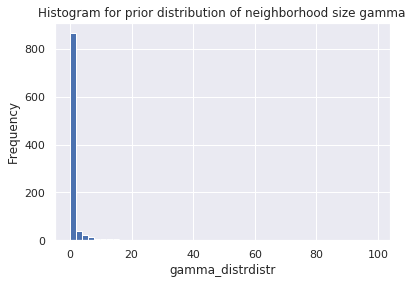

In [15]:
# Inspect prior distribution for gamma (Principal components)
gamma_distrdistr = hp.lognormal('C', np.log(1/30), 3.5)
samples = [pyll.stochastic.sample(gamma_distrdistr) for i in range(1000)]

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe(percentiles=[0.05, 0.5, 0.95]))

# Discard outliers before plotting 
samples = list(filter(lambda x: x<100, samples))
# Plot
# sns.distplot(pd.Series(samples))
pd.Series(samples).plot(kind='hist', bins=50)
# plt.xlim([0,1000])
plt.xlabel('gamma_distrdistr')
plt.title('Prior distribution of neighborhood size gamma')
plt.show()

Descriptive statistics:
 count    1.000000e+03
mean     1.303583e+01
std      3.178367e+02
min      9.825670e-09
5%       1.250487e-05
50%      9.169461e-03
95%      4.398888e+00
max      9.997066e+03
dtype: float64


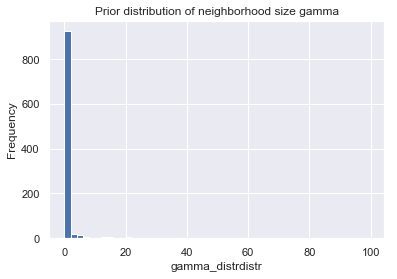

In [67]:
# Inspect prior distribution for gamma 
# (Original columns/no principal components)
gamma_distrdistr = hp.lognormal('C', np.log(1/130), 4)
samples = [pyll.stochastic.sample(gamma_distrdistr) for i in range(1000)]

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe(percentiles=[0.05, 0.5, 0.95]))

# Discard outliers before plotting 
samples = list(filter(lambda x: x<100, samples))
# Plot
# sns.distplot(pd.Series(samples))
pd.Series(samples).plot(kind='hist', bins=50)
# plt.xlim([0,1000])
plt.xlabel('gamma_distrdistr')
plt.title('Prior distribution of neighborhood size gamma')
plt.show()

For the regularization parameter C, we will also use a lognormal distribution. Since we want to center it at 1, we can simply pass a mean parameter of 0. To find the scale parameter, we experiment again to find reasonable values. Like for gamma, a common range is 0.001 to 1000. I choose a variance parameter of 5, but will later set an upper boundary of 10, which is usually large enough, because larger values take longer to train (up to an order of magnitude).  Since log-normal distributions are characterized by large positive outliers, and since the model is already computationally expensive, setting this upper threshold is useful.  As discussed in a previous notebook, hyperopt does not support setting upper or lower bounds by default.  Therefore, I add a function that adjusts the samples before passing them to the optimization, as well as before using the optimal parameters in other ways. If this threshold turns out to be too low, we will easily notice because the optimal value will be at the threshold. In this unlikely case, we will simply reestimate the model with gamma confined between 10 and 1000.

In [ ]:
# Inspect prior distribution for C
c_distr = hp.lognormal('C', 0, 3)
samples = [pyll.stochastic.sample(c_distr) for i in range(1000)]

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe(
          percentiles=[0.05, 0.5, 0.95]))

# Discard outliers before plotting
samples = list(filter(lambda x: x<100, samples))
# Plot
pd.Series(samples).plot(kind='hist', bins=50)
plt.xlabel('c_distr')
plt.title('Prior distribution of regularization strength')
plt.show()

This is the function that adjusts the parameters, making sure that C is not larger than 10:

In [14]:
def adjust_params_svm_rbf(params):
    """ 
    Adjust parameters where hyperopt did not allow sampling from optimal 
    distribution.
    """

    # Set min or max thresholds for parameters, where applicable
    if params['C'] >= 10:
        params['C'] = 10
        
    # Return modified parameters
    return params

Now let's define a function that carries out the Bayesian hyperparameter optimization, as explained in more detail in the previous notebook:

In [15]:
# Function to carry out hyperparameter optimization
def find_best_hp(CLF, space, model_name, 
                 X_train, y_train, 
                 adjust_params=None,n_folds=5, n_jobs=-1, max_evals=20):
    """Find best hyperparameters for a given classifier and search space."""
    
    # Trials object to track progress
    trials = Trials()

    # CSV file to track progress
    progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
    with open(progress_file_path, 'w') as file:
        writer = csv.writer(file)
        # Write header to the file
        writer.writerow(['loss', 'params'])

    # Objective function to minimize
    def objective(params, CLF=CLF, 
                  progress_file_path=progress_file_path,
                  n_folds=n_folds, n_jobs=n_jobs):
        """Objective function to minimize"""
        
        # Adjust parameters, if specified
        if adjust_params is not None:
            params = adjust_params(params)
    
        # Instantiate CLF
        clf = CLF(**params)
        
        ## Generate indices for cross-validation
        # If only one "fold" is desired, split into train and validation set
        if n_folds == 1: 
            cv = StratifiedShuffleSplit(n_splits=1, test_size=.2, 
                                        random_state=1)
        # Otherwise, generate indices for proper cross-validation split
        else:  
            cv = StratifiedKFold(n_folds, random_state=1)

        # Compute average precision through CV / validation set
        score = cross_val_score(clf, X_train, y_train, cv=cv,
                                scoring='average_precision', n_jobs=n_jobs)
        # Compute loss as the negative mean of the average precision scores
        # (since hyperopt can only minimize a function)
        loss = -score.mean()
        
        # Save results to csv file
        with open(progress_file_path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss, params])
        
        # Return results
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
    # Minimize objective
    best = fmin(objective, space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)

    # Get the values of the optimal parameters
    best_params = space_eval(space, best)
    # Adjust best parameters, if specified
    if adjust_params is not None:
        best_params = adjust_params(best_params)

    # Fit the model with the optimal hyperparamters
    clf = CLF(**best_params)
    clf.fit(X_train, y_train)
    
    # Save model to disk
    joblib.dump(clf, 'saved_models/' + model_name + '.joblib')
    
    # Print best parameters
    print(best_params)

In [ ]:
# Create directories to store models and progress files
!mkdir hp_progress saved_models

We are now ready to estimate the model. We will try two different versions, one using 80,000 observations from the principal components, and one using 40,000 observations with the original variables.

#### With principal components:

In [ ]:
# PRINCIPAL COMPONENTS
MAX_EVALS=40

# Define search space
space = {
    'kernel': 'rbf',
    'cache_size': 10000,
    'class_weight': 'balanced',
    'C': hp.lognormal('C', 0, 3),
    'gamma': hp.lognormal('gamma', np.log(1/30), 3.5)}

# Find best hyperparameters
find_best_hp(SVC, space, model_name='svm_rbf_pc_hp',
              X_train=X_train_pc_s, y_train=y_train_pc_s, 
              adjust_params=adjust_params_svm_rbf,
              max_evals=MAX_EVALS,n_folds=1, n_jobs=1)

In [10]:
# Load saved model from disk, if necessary
svm_rbf_pc_hp = joblib.load('saved_models/svm_rbf_pc_hp.joblib')

Best average precision score on *test* set: 0.3855
Best average precision score on *training* set: 0.3874


NameError: name 'average_precisions' is not defined

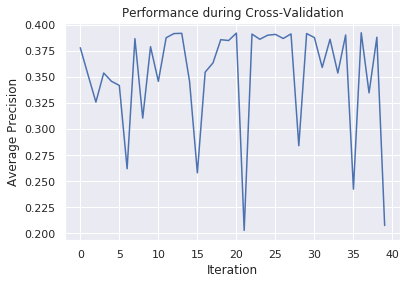

In [18]:
# Print and save average precision; save predictions
average_precisions['svm_rbf_pc'] = return_save_ap(
    svm_rbf_pc_hp, 'svm_rbf_pc_hp', X_test_pc, y_test,
    X_train=X_train_pc, y_train=y_train,
    validation_plot=True)

#### Original data/no principal components

In [ ]:
# Original columns/no principal components
MAX_EVALS=40

# Define search space
space = {
    'kernel': 'rbf',
    'cache_size': 10000,  # 10GB
    'class_weight': 'balanced',
    'C': hp.lognormal('C', 0, 3),
    'gamma': hp.lognormal('gamma', np.log(1/130), 3.5)}

# Find best hyperparameters
find_best_hp(SVC, space, model_name='svm_rbf_hp',
              X_train=X_train_s, y_train=y_train_s, 
              adjust_params=adjust_params_svm_rbf,
              max_evals=MAX_EVALS,n_folds=1, n_jobs=1)

In [ ]:
# Load saved model from disk, if necessary
svm_rbf_hp = joblib.load('saved_models/svm_rbf_hp.joblib')

Let's take a look at the average precision score of our model:

In [ ]:
# Calculate average precision
def return_save_ap(clf, model_name, X_test, y_test, 
                  X_train, y_train, validation_plot=False):
    """
    Returns, saves, and prints average precision score on train and test set; 
    saves score, As well as predictions, from *test* set. Optionally plots how 
    average precision changed over iterations (designed for hyperopt).
    """

    # Predict class
    y = clf.predict(X_test)
    # Save class prediction
    joblib.dump(y, f'predictions_test/y_{model_name}.joblib')
    
    # Predict class probabilities
    # Try if classifier supports probability
    try:
        y_score = clf.predict_proba(X_test)[:,1]
        y_score_train = clf.predict_proba(X_train)[:,1]
    # If it doesn't, use its decision function
    except AttributeError:
        y_score = clf.decision_function(X_test)
        y_score_train = clf.decision_function(X_train)
       
    # Save predictions for test set
    joblib.dump(y_score, f'predictions_test/y_score_{model_name}.joblib')
    
    # Calculate average precision
    ap_score = average_precision_score(y_test, y_score)
    ap_score_train = average_precision_score(y_train, y_score_train)
    
    # Print AP
    print('Best average precision score on *test* set: {:.4f}' \
              .format(ap_score))
    print('Best average precision score on *training* set: {:.4f}' \
              .format(ap_score_train))
    
    # Plot AP, if specified
    if validation_plot:
        # Load progress file with validation performance
        progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
        progress_file = pd.read_csv(progress_file_path)

        # Extract AP for each iteration
        ap = - progress_file.loss
        ap.plot()
        plt.title('Performance during Cross-Validation')
        plt.ylabel('Average Precision')
        plt.xlabel('Iteration');
        
    # Return average precision
    return ap_score

In [ ]:
# Create folder to store predictions for test set
! mkdir predictions_test

In [ ]:
# Initialize dictionaries to store results
average_precisions = {}
classification_reports = {}
classification_reports_default_thresholds = {}
feature_importances = {}

In [ ]:
# Print and save average precision; save predictions
average_precisions['svm_rbf'] = return_save_ap(
    svm_rbfhp, 'svm_rbf_hp', X_test, y_test,
    X_train=X_train, y_train=y_train,
    validation_plot=True)

#### Old version: Prior with gamma centered at 1/30

In [8]:
# Original columns/no principal components
MAX_EVALS=40

# Define search space
space = {
    'kernel': 'rbf',
    'cache_size': 10000,  # 10GB
    'class_weight': 'balanced',
    'C': hp.lognormal('C', 0, 3),
    'gamma': hp.lognormal('gamma', np.log(1/30), 3.5)}

# Find best hyperparameters
find_best_hp(SVC, space, model_name='svm_rbf_hp',
              X_train=X_train_s, y_train=y_train_s, 
              adjust_params=adjust_params_svm_rbf,
              max_evals=MAX_EVALS,n_folds=1, n_jobs=1)

{'C': 10, 'cache_size': 10000, 'class_weight': 'balanced', 'gamma': 0.0005310835142891282, 'kernel': 'rbf'}


In [4]:
# Load saved model from disk, if necessary
svm_rbf_hp = joblib.load('saved_models/svm_rbf_hp.joblib')

Let's take a look at the average precision score of our model:

In [5]:
# Calculate average precision
def return_save_ap(clf, model_name, X_test, y_test, 
                  X_train, y_train, validation_plot=False):
    """
    Returns, saves, and prints average precision score on train and test set; 
    saves score, As well as predictions, from *test* set. Optionally plots how 
    average precision changed over iterations (designed for hyperopt).
    """

    # Predict class
    y = clf.predict(X_test)
    # Save class prediction
    joblib.dump(y, f'predictions_test/y_{model_name}.joblib')
    
    # Predict class probabilities
    # Try if classifier supports probability
    try:
        y_score = clf.predict_proba(X_test)[:,1]
        y_score_train = clf.predict_proba(X_train)[:,1]
    # If it doesn't, use its decision function
    except AttributeError:
        y_score = clf.decision_function(X_test)
        y_score_train = clf.decision_function(X_train)
       
    # Save predictions for test set
    joblib.dump(y_score, f'predictions_test/y_score_{model_name}.joblib')
    
    # Calculate average precision
    ap_score = average_precision_score(y_test, y_score)
    ap_score_train = average_precision_score(y_train, y_score_train)
    
    # Print AP
    print('Best average precision score on *test* set: {:.4f}' \
              .format(ap_score))
    print('Best average precision score on *training* set: {:.4f}' \
              .format(ap_score_train))
    
    # Plot AP, if specified
    if validation_plot:
        # Load progress file with validation performance
        progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
        progress_file = pd.read_csv(progress_file_path)

        # Extract AP for each iteration
        ap = - progress_file.loss
        ap.plot()
        plt.title('Performance during Cross-Validation')
        plt.ylabel('Average Precision')
        plt.xlabel('Iteration');
        
    # Return average precision
    return ap_score

In [9]:
# Create folder to store predictions for test set
! mkdir predictions_test

In [6]:
# Initialize dictionaries to store results
average_precisions = {}
classification_reports = {}
classification_reports_default_thresholds = {}
feature_importances = {}

Best average precision score on *test* set: 0.3965
Best average precision score on *training* set: 0.3971


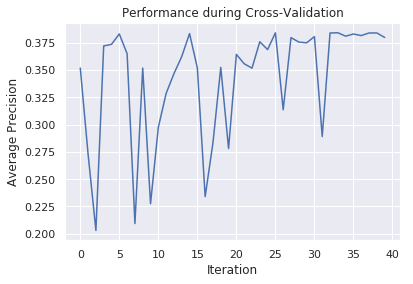

In [7]:
# Print and save average precision; save predictions
average_precisions['svm_rbf'] = return_save_ap(
    svm_rbfhp, 'svm_rbf_hp', X_test, y_test,
    X_train=X_train, y_train=y_train,
    validation_plot=True)

## Save/Load

In [21]:
# Save
joblib.dump(average_precisions, 'saved_models/average_precisions.joblib')
joblib.dump(feature_importances, 'saved_models/feature_importances.joblib')

['saved_models/feature_importances.joblib']

In [11]:
# Load
average_precisions = joblib.load('saved_models/average_precisions.joblib')
feature_importances = joblib.load('saved_models/feature_importances.joblib')

In [12]:
average_precisions

{'lr': 0.39224740694750637,
 'svm_lin': 0.3913884831950885,
 'rf': 0.3939554379468981,
 'xgb': 0.41414888290960883}

In [14]:
feature_importances.keys()

dict_keys(['xgb', 'lr'])

In [9]:
1+1

2